In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
#Kütüphaneler projeye ekleniyor.

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
#Verilen url'ye göre veri seti indiriliyor.

84140032/84125825 [==============================] - 3s 0us/step


In [ ]:
train_dir = os.path.join(dataset_dir, 'train')


In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
batch_size = 250 #bir tekrarda işlenen örnek sayısı
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training',
    shuffle=True,
    seed=seed)
#Eğitim 3'e ayrıldı. Bu kısım train kısmı.

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)
#Eğitimin doğrulama kısmı

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)
#Eğitimin test kısmı

Found 25000 files belonging to 2 classes.


In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
  #stringleri okunabilir şekilde yeniden yapılandırır.

In [ ]:
max_features = 10000
sequence_length =500

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
#Verileri vektörleştirmek için kullanılan katman.
#Model tam sayılara dizi dizini oluşturur.

In [ ]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)
#İşlenmemiş metin veri kümesi haline getirilir.

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label
  #Veri kümesi haline gelen metni test eder.

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label)) 
#Çekilen yorumdaki her kelime bir sayıyı temsil eder.
#Yoruma göre sayı matrisi oluşturulur.

Review tf.Tensor(b'Prominent attorney Walter Pidgeon takes a murder case pro bono, wins an acquittal and discovers that his client (Keefe Braselle) was not only guilty but part of an extortion ring reaching to the highest eschelons of the city. Panged by his own complicity, he undertakes an investigation, stumbles onto the identity of the "unknown man" who heads the syndicate, and murders him.<br /><br />The ironies engage when Braselle is charged with this second murder and Pidgeon must defend him by pointing to the existence of another "unknown man" -- himself. Though somewhat short of urban grit and long on rhetoric, the Unknown Man belongs to the noir cycle less by style or structure than by its acknowledgement of the pervasive corruption of American municipal politics that came to light in the postwar years.', shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 500), dtype=int64, numpy=
array([[5511, 4964, 2312,    1,  294,    4,  578,  401, 5369,    1, 2758

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
#TextVectorization katmanı train doğrulama ve test, veri kümesine uygular.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()
#Bu katman, tamsayı kodlu incelemeleri alır ve her bir 
#kelime dizini için bir gömme vektörü arar. 
#Bu vektörler model trainler olarak öğrenilir.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0)) 
#Kayıp fonksiyonu, optimize edici fonksiyon.

In [ ]:
epochs = 100 #Bir döngüde öğrenilen veri sayısı.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/100
80/80 [==============================] - 9s 94ms/step - loss: 0.6912 - binary_accuracy: 0.5653 - val_loss: 0.6890 - val_binary_accuracy: 0.6312
Epoch 2/100
80/80 [==============================] - 3s 32ms/step - loss: 0.6853 - binary_accuracy: 0.6449 - val_loss: 0.6818 - val_binary_accuracy: 0.6850
Epoch 3/100
80/80 [==============================] - 3s 33ms/step - loss: 0.6754 - binary_accuracy: 0.6865 - val_loss: 0.6708 - val_binary_accuracy: 0.7102
Epoch 4/100
80/80 [==============================] - 3s 32ms/step - loss: 0.6618 - binary_accuracy: 0.7183 - val_loss: 0.6563 - val_binary_accuracy: 0.7344
Epoch 5/100
80/80 [==============================] - 3s 32ms/step - loss: 0.6449 - binary_accuracy: 0.7430 - val_loss: 0.6395 - val_binary_accuracy: 0.7542
Epoch 6/100
80/80 [==============================] - 3s 33ms/step - loss: 0.6258 - binary_accuracy: 0.7649 - val_loss: 0.6213 - val_binary_accuracy: 0.7620
Epoch 7/100
80/80 [==============================] - 3s 33ms/ste

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy) 
#ekrana kayıp değerleri ve doğrulama değerlerini yazdırır.

100/100 [==============================] - 7s 63ms/step - loss: 0.2984 - binary_accuracy: 0.8840
Loss:  0.298371285200119
Accuracy:  0.8840000033378601


In [ ]:
history_dict = history.history
history_dict.keys()
#Eğitim sırasındaki her şeyi history nesnesi döndürür.

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

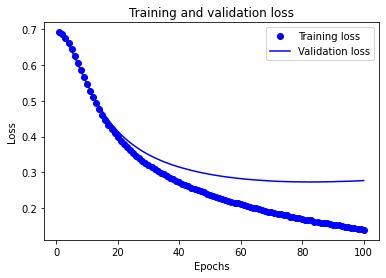

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
#kayıpları grafik haline getirip ekrana yazar.

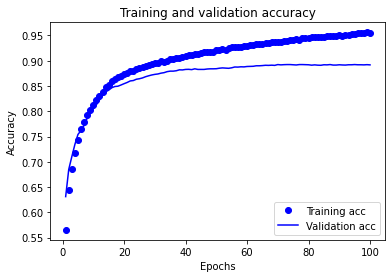

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()
#Doğruluk grafiği oluşturup ekrana yazar.

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)
#model dışa aktarılır.

100/100 [==============================] - 7s 65ms/step - loss: 0.2984 - accuracy: 0.8840
0.8840000033378601


In [ ]:
examples = [
  "The Silence of the Lambs, having accomplished the rare feat of winning all five of the major Academy Award categories, is a remarkable achievement in filmmaking. Gruesome, pulpish material was transformed by dedicated participants on all levels of production, and a film that would have failed in the hands of many others wound up becoming a modern masterpiece. Taut direction and a superb screenplay might be the best arguments for the film's power, but the flashiest are certainly delivered in the bravura performances of Hopkins and Foster. Their interplay -- and remember, they only share a handful of scenes together -- is nothing short of riveting.",
  "okay",
  "best",
  "worst"
]

export_model.predict(examples)
#Veriler girildiğinde test eder. Çıkan sayılar 1'e doğru yaklaştıkça yorum o kadar pozitiftir.

array([[0.87786806],
       [0.36358368],
       [0.57472616],
       [0.23659453]], dtype=float32)